In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import seaborn as sns

## Loading main dataset
A Sentiment Classification in Bengali and Machine Translated English Corpus

In [2]:
df = pd.read_csv(r'D:\codes\begali_sentiment\all_data.csv', index_col=False)

In [3]:
df.head(2)

,text,label
0,"আমার বাংলাদেশের নাটকের ভুতে ধরেছে, ওঝা কোথায় প...",0
1,"ভাই, আপনার হার্ড ফ্যান আমি!বাট এইযে এই নাটকে য...",1


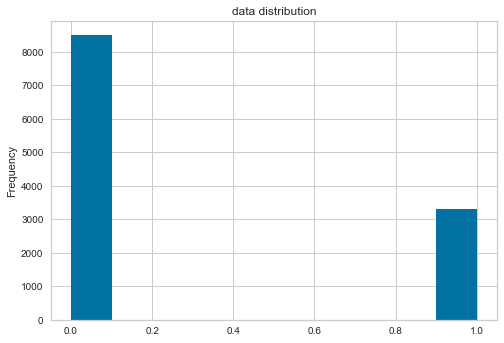

In [60]:
df['label'].plot(kind='hist', title='data distribution')

## Train Test split 1/3
*7871 training samples 
*3937 validation samples

In [157]:
train_df, valid_df = train_test_split(df, random_state=42, train_size=0.6666, stratify=df.label.values)
train_df.shape, valid_df.shape

((7871, 2), (3937, 2))

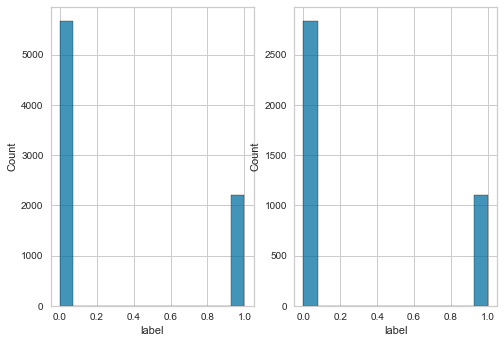

In [158]:
f, axes = plt.subplots(1, 2)
sns.histplot(data=train_df, x='label', ax=axes[0])
sns.histplot(data=valid_df, x='label', ax=axes[1])

## Heading Model Declaration
Model description:
- embedding layer: [(cc_bn_300 fasttext word vector)](https://fasttext.cc/docs/en/crawl-vectors.html)
- Dense layer: 256, with relu activation
- Dense layer: 64, with relu activation
- Dense layer: 32, with relu activation
- Dense layer: 1, with sigmoid activation (binary classification)

Optimizer:
- Adam: lr = 0.0001 (transfer learning, we can easily over-fit)

Loss:
- Binary Cross-entropy (binary classification)

Metrics:
- Binary Accuracy (imbalanced distribution)


In [43]:
def create_model(module_path, embed_size, name, trainable=False):
    hub_layer = hub.KerasLayer(module_path, input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)

    model = tf.keras.models.Sequential([
                                    hub_layer,
                                    tf.keras.layers.Dense(256, activation='relu'),
                                    tf.keras.layers.Dense(64, activation='relu'),
                                    tf.keras.layers.Dense(32, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')                               
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.metrics.BinaryAccuracy(name='accuracy')]
    )

    model.summary()

    return model

In [44]:
model = create_model(r'D:\codes\495\wordEmbed\text_module', 300, 'cc_bn_300-finetuned', trainable=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 300)               30000300  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               77056     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 30,095,917
Trainable params: 30,095,917
Non-trainable params: 0
_________________________________________________________________


In [45]:
histories = {}

## Training Model (cc_bn_300-finetuned)
Training will stop if the validation loss does not improve for two consecutive epochs 

In [46]:
histories['cc_bn_300-finetuned'] = model.fit(train_df['text'], train_df['label'],
                        epochs=100,
                        batch_size=32,
                        validation_data=(valid_df['text'], valid_df['label']),
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min'),
                                tf.keras.callbacks.ModelCheckpoint('cc_bn_300-finetuned-32_mdl', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
                        ],
                        verbose=1
)

Epoch 1/100
246/246 [==============================] - 103s 418ms/step - loss: 0.5953 - accuracy: 0.7144 - val_loss: 0.2611 - val_accuracy: 0.9081

Epoch 00001: val_loss improved from inf to 0.26107, saving model to cc_bn_300-finetuned-32_mdl
INFO:tensorflow:Assets written to: cc_bn_300-finetuned-32_mdl\assets
Epoch 2/100
246/246 [==============================] - 102s 415ms/step - loss: 0.2100 - accuracy: 0.9248 - val_loss: 0.1676 - val_accuracy: 0.9347

Epoch 00002: val_loss improved from 0.26107 to 0.16759, saving model to cc_bn_300-finetuned-32_mdl
INFO:tensorflow:Assets written to: cc_bn_300-finetuned-32_mdl\assets
Epoch 3/100
246/246 [==============================] - 103s 417ms/step - loss: 0.1230 - accuracy: 0.9513 - val_loss: 0.1561 - val_accuracy: 0.9434

Epoch 00003: val_loss improved from 0.16759 to 0.15610, saving model to cc_bn_300-finetuned-32_mdl
INFO:tensorflow:Assets written to: cc_bn_300-finetuned-32_mdl\assets
Epoch 4/100
246/246 [==============================] - 1

## Accuracy and Loss Curves

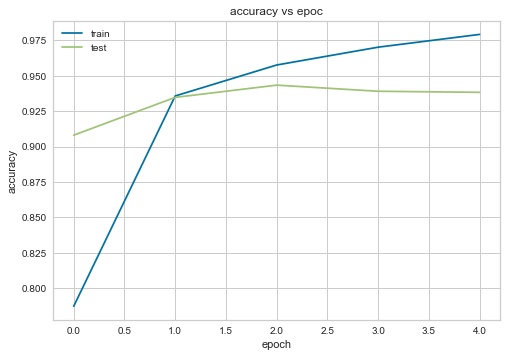

In [159]:
plt.plot(histories['cc_bn_300-finetuned'].history['accuracy'])
plt.plot(histories['cc_bn_300-finetuned'].history['val_accuracy'])
plt.title('accuracy vs epoc')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

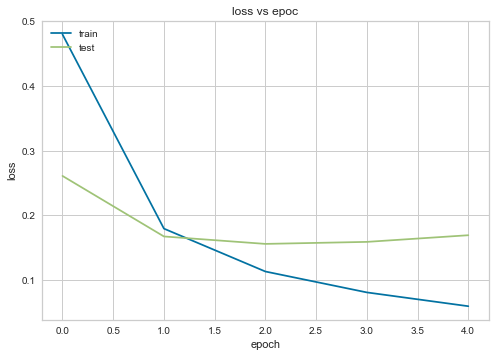

In [160]:
plt.plot(histories['cc_bn_300-finetuned'].history['loss'])
plt.plot(histories['cc_bn_300-finetuned'].history['val_loss'])
plt.title('loss vs epoc')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Classification Report for Test Data

In [178]:
y_pred = (model.predict(valid_df['text']) > 0.5).astype("int32")
target_names = ['class 0: Positive', 'class 1: Negative']
print(classification_report(valid_df['label'], y_pred, target_names=target_names))

                   precision    recall  f1-score   support

class 0: Positive       0.95      0.96      0.96      2834
class 1: Negative       0.90      0.88      0.89      1103

         accuracy                           0.94      3937
        macro avg       0.92      0.92      0.92      3937
     weighted avg       0.94      0.94      0.94      3937



## Loading some collected data from Social Media Threds

In [179]:
social_media_comments = pd.read_csv(r'D:\codes\begali_sentiment\social_media_comments.csv')
social_media_comments.shape

(69, 2)

In [180]:
social_media_comments.head(2)

,text,label
0,মেয়ে পদা করে চললে এই রকম ধষন হবে না,1
1,নারীর অধিকার নিয়ে যারা লাফালাফি করে তারা আজ কো...,1


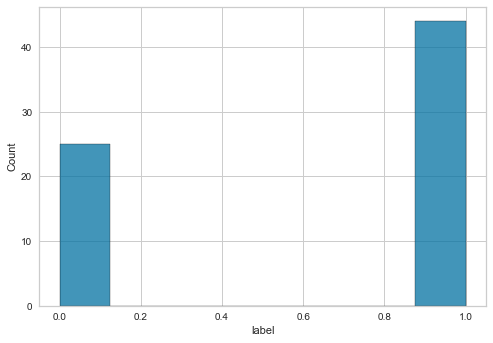

In [181]:
sns.histplot(data=social_media_comments, x=social_media_comments.label)

## Classification Report on some Social Media comments on topics like sexual harassment, sexual assault and homosexuality 

In [182]:
y_pred = (model.predict(social_media_comments.text.values) > 0.3).astype("int32")

for index, sample in social_media_comments.iterrows():
    print('text: {} -> predicted: {} -> labeled: {}'
                .format(sample['text'], 
                        '[insincere]' if y_pred[index] == 1 else '[sincere]' , 
                        '[insincere]' if sample['label'] == 1 else '[sincere]' 
                )
    )

text: মেয়ে পদা করে চললে এই রকম ধষন হবে না -> predicted: [insincere] -> labeled: [insincere]
text: নারীর অধিকার নিয়ে যারা লাফালাফি করে তারা আজ কোথায়? -> predicted: [insincere] -> labeled: [insincere]
text: আপনারা উন্নয়ন করেছেন তাই জন্য ধন্যবাদ। -> predicted: [sincere] -> labeled: [sincere]
text: সারা দেশে উন্নত যোগাযোগ বাবস্থা চাই -> predicted: [sincere] -> labeled: [sincere]
text: আমরা একাত্তর টিভি বয়কট করেছি -> predicted: [insincere] -> labeled: [insincere]
text: সব চুরদের বড় চুর ৭১টিভি -> predicted: [insincere] -> labeled: [insincere]
text: সব শালা চোর। -> predicted: [insincere] -> labeled: [insincere]
text: হলুদ সাংবাদিকতা বন্ধ করুন। -> predicted: [insincere] -> labeled: [insincere]
text: ৭১ টিভিরে জুরে একটা লাথি মারি -> predicted: [insincere] -> labeled: [insincere]
text: রাষ্ট্র ও রাষ্ট্রধর্ম রাষ্ট্রের মৌলিক উপাদান ৪টি। -> predicted: [insincere] -> labeled: [sincere]
text: বাংলাদেশ ক্রিকেট জগৎ, বাংলাদেশের ক্রিকেটের লাইভ ভিডিও সহকারে আপডেট পেতে লাইক দিন পেজে। -> predicted: [sincere

In [183]:
print(classification_report(social_media_comments.label.values , y_pred, target_names=target_names))

                   precision    recall  f1-score   support

class 0: Positive       0.85      0.68      0.76        25
class 1: Negative       0.84      0.93      0.88        44

         accuracy                           0.84        69
        macro avg       0.84      0.81      0.82        69
     weighted avg       0.84      0.84      0.84        69



## Quora Insincere Questions Classification [Dataset](https://www.kaggle.com/c/quora-insincere-questions-classification/data)

- Machine Traslated to Bangla using [goolgetrans](https://pypi.org/project/googletrans/)
- Using 1293 samples

In [184]:
quora_translated = pd.read_csv(r'D:\codes\begali_sentiment\quora_questio_data_valid.csv')
quora_translated.shape

(1293, 3)

In [185]:
quora_translated.head(4)

,question_text,target,translation
0,Should go for CCIE (security) as a fresher?,0,একটি fresher হিসাবে CCIE (নিরাপত্তা) জন্য যেতে...
1,What has inspired K'naan to write his poems?,0,কি'নানকে তার কবিতা লিখতে অনুপ্রাণিত করেছে?
2,Why does my boyfriend not enjoy pleasing me se...,0,কেন আমার প্রেমিক আমাকে যৌন আনন্দ উপভোগ করেন না?
3,What does being a coward mean to you?,0,একটি কাপুরুষ হচ্ছে আপনি কি মানে?


## Classification Report of Machine Translated Quora Insincere Questions Dataset

In [186]:
y_pred = (model.predict(quora_translated.translation.values) > 0.93).astype("int32")
print(classification_report(quora_translated.target.values, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

class 0: Positive       0.94      0.92      0.93      1213
class 1: Negative       0.10      0.14      0.12        80

         accuracy                           0.87      1293
        macro avg       0.52      0.53      0.52      1293
     weighted avg       0.89      0.87      0.88      1293



##  Polarity Detection of Bengali Book Reviews [Dataset](https://data.mendeley.com/datasets/2wcw3sxxr3/1)
- 1443 samples
- 972 positive
- 471 negative

In [187]:
book_reviews = pd.read_csv(r'D:\codes\begali_sentiment\BookReviews.csv')

In [188]:
book_reviews.shape
book_reviews.tail(4)

,Unnamed: 0,Review,Sentiment,mirror_label
1440,1440,একটু আগে পড়ে শেষ করলাম ।কাহিনী টা আমার কাছে দা...,1,0
1441,1441,মুক্তি যুদ্ধ সম্পর্কে পড়া আমার সেরা বই। অনেক ক...,1,0
1442,1442,আশাকরি ভালো একটা বই পাবো এইভাবেই এই অনুবাদকের ...,1,0
1443,1443,নবীন প্রোগ্রামারদের জন্যে অসাধারন একটা বই। আমি...,1,0


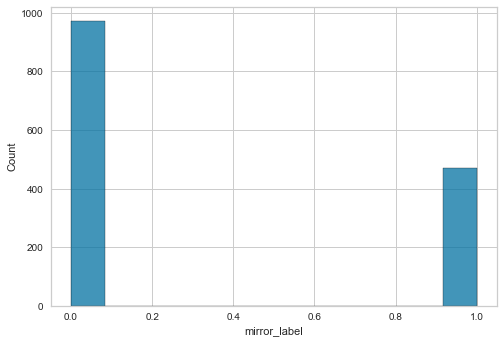

In [189]:
sns.histplot(data=book_reviews, x=book_reviews.mirror_label)

## Classification Report of Bengali Books Review Dataset

In [190]:
y_pred = (model.predict(book_reviews.Review.values) > 0.4).astype("int32")
print(classification_report(book_reviews.mirror_label.values, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

class 0: Positive       0.88      0.96      0.92       972
class 1: Negative       0.90      0.72      0.80       472

         accuracy                           0.88      1444
        macro avg       0.89      0.84      0.86      1444
     weighted avg       0.88      0.88      0.88      1444



## Allocine [Dataset](https://github.com/TheophileBlard/french-sentiment-analysis-with-bert/tree/master/allocine_dataset): French movie reviews
- using 1200 samples
- Machine Traslated to Bangla using [goolgetrans](https://pypi.org/project/googletrans/)

In [191]:
french_movie_reviews = pd.read_csv(r'D:\codes\begali_sentiment\french_movie_review_1200.csv')
french_movie_reviews.shape

(1200, 3)

In [192]:
french_movie_reviews.head(2)

,review,polarity,translated
0,"Ce n'est pas un film policier - ""intrigue"" à l...",1,"এটি একটি পুলিশি সিনেমা নয় - ""ষড়যন্ত্র"" উভয় ..."
1,Mouais... C'est quand même un peu gros et arra...,1,হ্যাঁ ... এটি এখনও একটু বড় এবং কখনও কখনও ব্যব...


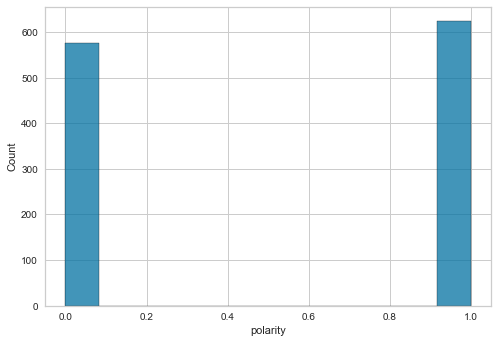

In [193]:
sns.histplot(data=french_movie_reviews, x=french_movie_reviews.polarity)

## Classification Report on Machine Translated French Movie Reviews

In [194]:
y_pred = (model.predict(french_movie_reviews.translated.values) > 0.012312).astype("int32")
print(classification_report(french_movie_reviews.polarity.values, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

class 0: Positive       0.58      0.85      0.69       576
class 1: Negative       0.76      0.44      0.56       624

         accuracy                           0.64      1200
        macro avg       0.67      0.65      0.63      1200
     weighted avg       0.68      0.64      0.62      1200



## Bangla Abusive Comment [Dataset](https://github.com/aimansnigdha/Bangla-Abusive-Comment-Dataset)

In [195]:
bengali_toxic = pd.read_csv(r'D:\codes\begali_sentiment\bengali_toxic_comment.csv')
bengali_toxic.shape

(10220, 2)

In [196]:
bengali_toxic.tail(4)

,text,label
10216,দুইমাসের বাচ্চারে যে মা দুধের অভাবে লবণ খাওয়াই...,0
10217,ফাস্টেস্ট গ্রোয়িং আল্ট্রা হাই নেট-ওয়র্থ দের উল...,0
10218,সেটাই তো করি ভাই। ঘাস লতা পাতা ইত্যাদি নিয়া থাকি।,0
10219,মাঝেমধ্যে ভুইলা যাই...তখন আবেগ এসে পড়ে,0


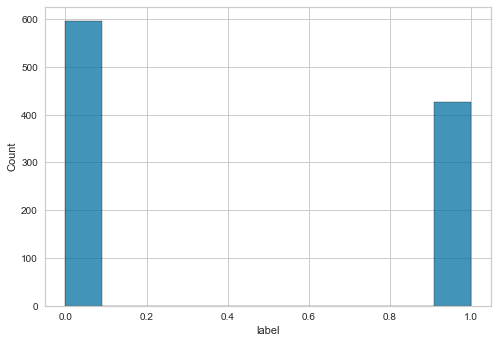

In [197]:
sns.histplot(data=bengali_toxic_comment, x=bengali_toxic_comment.label)

## Classification Report: Bangla Abusive Comment

In [198]:
y_pred = (model.predict(bengali_toxic_comment.text.values, batch_size=32) > 0.5).astype("int32")
print(classification_report(bengali_toxic_comment.label.values, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

class 0: Positive       0.88      0.44      0.58       596
class 1: Negative       0.54      0.91      0.68       426

         accuracy                           0.64      1022
        macro avg       0.71      0.68      0.63      1022
     weighted avg       0.73      0.64      0.62      1022

